2025-05-05 13:45:32,681 - INFO - Loading base model: runwayml/stable-diffusion-v1-5


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

2025-05-05 13:46:52,130 - INFO - Using GPU for inference
2025-05-05 13:46:52,131 - INFO - Loading LoRA weights from: models/sd15_lora_logos/final
2025-05-05 13:46:52,568 - INFO - Loaded state dict with 192 keys
2025-05-05 13:46:52,571 - INFO - Found 64 attention modules to apply LoRA
2025-05-05 13:46:52,571 - INFO - Applied LoRA to 0 modules
2025-05-05 13:46:52,572 - INFO - Using random seed: 836599
2025-05-05 13:46:52,573 - INFO - Using seed: 836599
2025-05-05 13:46:52,574 - INFO - Generating for prompt: A logo for a technology company named 'ByteWave', minimalist style, with blue gradient colors
2025-05-05 13:46:52,574 - INFO - Generating sample 1/1


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-05 13:47:02,279 - INFO - Saved image to: examples/ByteWave_technology_company_0.png
2025-05-05 13:47:02,280 - INFO - Generating for prompt: A logo for a coffee shop named 'Morning Brew', modern style, with brown colors and coffee bean icon
2025-05-05 13:47:02,281 - INFO - Generating sample 1/1


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-05 13:47:05,981 - INFO - Saved image to: examples/Morning Brew_coffee_shop_0.png
2025-05-05 13:47:05,982 - INFO - Generating for prompt: A logo for a fitness center named 'PEAK', bold style, with black and red colors, mountain silhouette
2025-05-05 13:47:05,982 - INFO - Generating sample 1/1


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-05 13:47:09,671 - INFO - Saved image to: examples/PEAK_fitness_center_0.png
2025-05-05 13:47:09,673 - INFO - Generating for prompt: A logo for a bakery named 'Sweet Delights', vintage style, with pastel colors and cupcake icon
2025-05-05 13:47:09,673 - INFO - Generating sample 1/1


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-05 13:47:13,413 - INFO - Saved image to: examples/Sweet Delights_bakery_0.png
2025-05-05 13:47:13,414 - INFO - Generating for prompt: A logo for a photography studio named 'Capture Moments', elegant style, with camera icon
2025-05-05 13:47:13,415 - INFO - Generating sample 1/1


  0%|          | 0/50 [00:00<?, ?it/s]

2025-05-05 13:47:17,174 - INFO - Saved image to: examples/Capture Moments_photography_studio_0.png
2025-05-05 13:47:18,202 - INFO - Saved gallery to: examples/logo_examples_gallery.png
2025-05-05 13:47:18,203 - INFO - Generated examples for README. Markdown saved to examples/README_examples.md
2025-05-05 13:47:18,204 - INFO - Copy the contents of this file to your README.md


README examples generated and saved to the 'examples' directory.
Open examples/README_examples.md to see the markdown for your README.


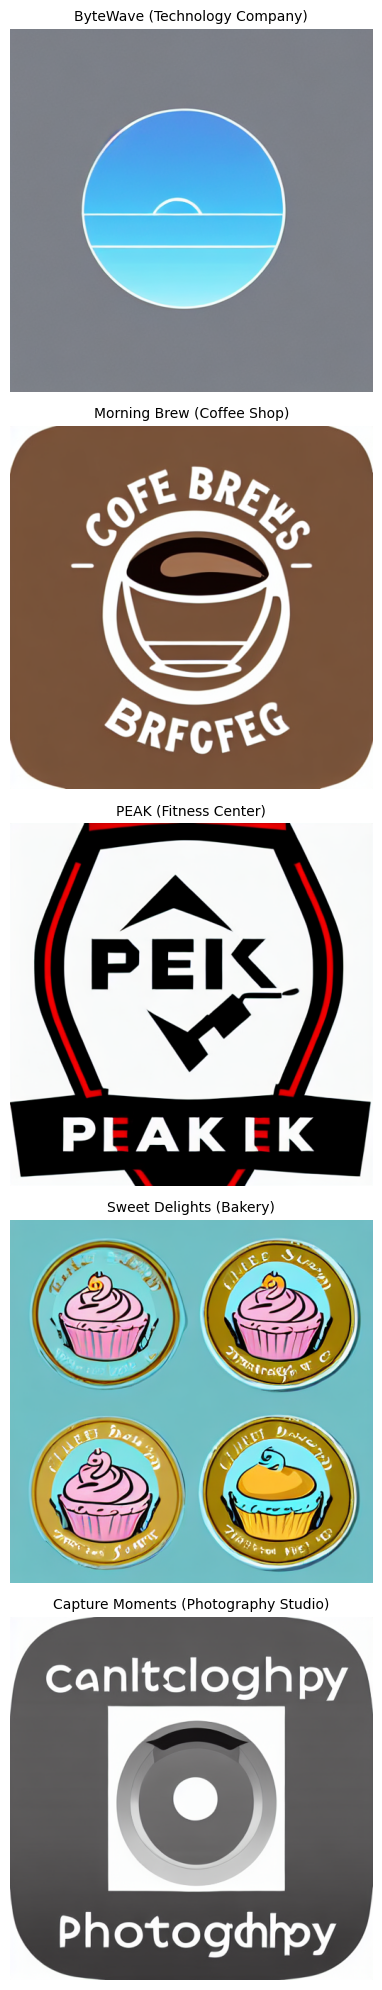

In [1]:
# Script to generate logo examples for README documentation

import os
import torch
import random
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def create_safe_filename(prompt, index=0, max_length=50):
    """Create a safe filename from a prompt"""
    # Replace invalid filename characters with underscores
    safe_name = ''.join(c if c.isalnum() or c in [' ', '_', '-'] else '_' for c in prompt)
    # Replace spaces with underscores
    safe_name = safe_name.replace(' ', '_')
    # Truncate to reasonable length and add index
    truncated = safe_name[:max_length] if len(safe_name) > max_length else safe_name
    # Add index to make filenames unique
    return f"{truncated}_{index}.png"

def load_lora_model(checkpoint_path, base_model="runwayml/stable-diffusion-v1-5"):
    """Loading the base model and apply LoRA weights from checkpoint"""
    logger.info(f"Loading base model: {base_model}")
    
    # Loading the base pipeline
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    
    # Move to GPU if available
    if torch.cuda.is_available():
        pipe = pipe.to("cuda")
        logger.info("Using GPU for inference")
    else:
        logger.info("Using CPU for inference (slow)")
    
    # Loading and applying LoRA weights
    if checkpoint_path:
        logger.info(f"Loading LoRA weights from: {checkpoint_path}")
        
        # Loading the safetensors file
        import safetensors.torch
        weights_file = os.path.join(checkpoint_path, "pytorch_lora_weights.safetensors")
        
        if not os.path.exists(weights_file):
            logger.error(f"Weights file not found: {weights_file}")
            return pipe
        
        state_dict = safetensors.torch.load_file(weights_file)
        logger.info(f"Loaded state dict with {len(state_dict)} keys")
        
        # Creating a custom forward function for attention modules
        def add_lora_to_module(module_name, module):
            """Add LoRA to specific modules"""
            orig_forward = module.forward
            
            def forward_with_lora(hidden_states, *args, **kwargs):
                # Original output
                output = orig_forward(hidden_states, *args, **kwargs)
                
                # Getting module path in state dict format
                module_path = module_name.replace(".", "_")
                
                # Checking if we have LoRA weights for this module
                lora_down_key = f"{module_path}.lora_down.weight"
                lora_up_key = f"{module_path}.lora_up.weight"
                scale_key = f"{module_path}.scale"
                
                if lora_down_key in state_dict and lora_up_key in state_dict:
                    # Getting LoRA weights
                    lora_down = state_dict[lora_down_key].to(hidden_states.device, hidden_states.dtype)
                    lora_up = state_dict[lora_up_key].to(hidden_states.device, hidden_states.dtype)
                    
                    # Get scale (or default to 1.0)
                    scale = 1.0
                    if scale_key in state_dict:
                        if isinstance(state_dict[scale_key], torch.Tensor):
                            scale = state_dict[scale_key].item()
                        else:
                            scale = state_dict[scale_key]
                    
                    # Applying LoRA
                    # hidden_states: [batch, seq_len, dim]
                    # lora_down: [rank, dim]
                    if hidden_states.dim() == 3:
                        # Reshape for batch processing
                        batch, seq_len, dim = hidden_states.shape
                        h_flat = hidden_states.reshape(-1, dim)
                        
                        # Appling LoRA
                        lora_output = h_flat @ lora_down.t() @ lora_up
                        lora_output = lora_output.reshape(batch, seq_len, -1)
                        
                        # Adding to original output with scaling
                        output = output + (scale * lora_output)
                
                return output
            
            # Replacing forward method
            module.forward = forward_with_lora
        
        # Applying LoRA to attention modules
        attn_modules = []
        for name, module in pipe.unet.named_modules():
            if "attn1.to_q" in name or "attn1.to_k" in name or "attn1.to_v" in name or "attn1.to_out.0" in name:
                attn_modules.append((name, module))
        
        logger.info(f"Found {len(attn_modules)} attention modules to apply LoRA")
        
        # Applying LoRA to each module
        lora_count = 0
        for name, module in attn_modules:
            # Converting module name format to state dict format
            module_name = name
            
            # Checking if this module has LoRA weights
            module_path = module_name.replace(".", "_")
            lora_down_key = f"{module_path}.lora_down.weight"
            lora_up_key = f"{module_path}.lora_up.weight"
            
            if lora_down_key in state_dict and lora_up_key in state_dict:
                add_lora_to_module(module_name, module)
                lora_count += 1
        
        logger.info(f"Applied LoRA to {lora_count} modules")
    
    return pipe

def generate_logos(pipe, prompts, num_samples=1, seed=None, save_dir="examples", **kwargs):
    """Generate logo samples for each prompt and save them to disk"""
    results = {}
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Setting a generator for reproducibility if seed is provided
    generator = None
    if seed is not None:
        generator = torch.Generator(device=pipe.device).manual_seed(seed)
        logger.info(f"Using seed: {seed}")
    
    # Generating images for each prompt
    for prompt in prompts:
        images = []
        
        # Create a clean prompt for logging
        clean_prompt = prompt.replace('\n', ' ').strip()
        logger.info(f"Generating for prompt: {clean_prompt}")
        
        # Get business type and company name for nicer filenames
        try:
            business_type = prompt.split("named")[0].split("for a ")[1].strip()
            company_name = prompt.split("named '")[1].split("'")[0].strip()
            nice_filename = f"{company_name}_{business_type.replace(' ', '_')}"
        except:
            # Fallback to a simple filename if parsing fails
            nice_filename = create_safe_filename(clean_prompt, 0, max_length=30)
        
        # Generating multiple samples per prompt
        for i in range(num_samples):
            logger.info(f"Generating sample {i+1}/{num_samples}")
            
            # Setting a different seed for each sample if a base seed is provided
            sample_generator = None
            if generator is not None:
                sample_generator = torch.Generator(device=pipe.device).manual_seed(seed + i)
            
            # Generating image
            image = pipe(
                prompt, 
                num_inference_steps=50,
                guidance_scale=7.5,
                generator=sample_generator,
                **kwargs
            ).images[0]
            
            # Save the image with a descriptive filename
            filename = f"{nice_filename}_{i}.png"
            save_path = os.path.join(save_dir, filename)
            image.save(save_path)
            logger.info(f"Saved image to: {save_path}")
            
            # Create a prompt file to store the original prompt text
            if i == 0:  # Only save the prompt once
                prompt_file = os.path.join(save_dir, f"{nice_filename}_prompt.txt")
                with open(prompt_file, "w") as f:
                    f.write(prompt)
                
                # Also save the markdown snippet for README
                readme_snippet = f"### {company_name} ({business_type.title()})\n"
                readme_snippet += f"![{company_name} Logo](examples/{filename})\n"
                readme_snippet += f"*Prompt: \"{prompt}\"*\n\n"
                
                with open(os.path.join(save_dir, f"{nice_filename}_markdown.md"), "w") as f:
                    f.write(readme_snippet)
            
            images.append(image)
        
        # Storing results for this prompt
        results[prompt] = images
    
    return results

def generate_readme_gallery(results, save_dir="examples"):
    """Generate a gallery image of all results for the README"""
    # Count total number of prompts and samples
    num_prompts = len(results)
    num_samples = max(len(images) for _, images in results.items())
    
    # Create a figure with enough room for all images
    plt.figure(figsize=(num_samples * 4, num_prompts * 4))
    
    # Plot all images in a grid
    for i, (prompt, images) in enumerate(results.items()):
        # Try to extract business type and company name for better titles
        try:
            business_type = prompt.split("named")[0].split("for a ")[1].strip()
            company_name = prompt.split("named '")[1].split("'")[0].strip()
            title = f"{company_name} ({business_type.title()})"
        except:
            title = prompt[:30] + "..." if len(prompt) > 30 else prompt
        
        for j, image in enumerate(images):
            plt.subplot(num_prompts, num_samples, i * num_samples + j + 1)
            plt.imshow(image)
            
            # Only add the full title to the first image in each row
            if j == 0:
                plt.title(title, fontsize=10)
            else:
                plt.title(f"Sample {j+1}", fontsize=10)
            
            plt.axis('off')
    
    plt.tight_layout()
    
    # Save the gallery
    gallery_path = os.path.join(save_dir, "logo_examples_gallery.png")
    plt.savefig(gallery_path)
    logger.info(f"Saved gallery to: {gallery_path}")
    
    # Also save a markdown snippet to include the gallery in the README
    gallery_md = "## Example Gallery\n\n"
    gallery_md += "![Logo Examples Gallery](examples/logo_examples_gallery.png)\n\n"
    
    with open(os.path.join(save_dir, "gallery_markdown.md"), "w") as f:
        f.write(gallery_md)
    
    return gallery_path

def generate_readme_examples():
    """Generate a set of diverse examples for the README"""
    # Create a set of diverse prompts that showcase different business types
    example_prompts = [
        "A logo for a technology company named 'ByteWave', minimalist style, with blue gradient colors",
        "A logo for a coffee shop named 'Morning Brew', modern style, with brown colors and coffee bean icon",
        "A logo for a fitness center named 'PEAK', bold style, with black and red colors, mountain silhouette",
        "A logo for a bakery named 'Sweet Delights', vintage style, with pastel colors and cupcake icon",
        "A logo for a photography studio named 'Capture Moments', elegant style, with camera icon"
    ]
    
    # Ensure the examples directory exists
    os.makedirs("examples", exist_ok=True)
    
    # Create checkpoint path
    checkpoint_path = "models/sd15_lora_logos/final"
    
    # Load model
    pipe = load_lora_model(checkpoint_path)
    
    # Generate logos with seed for reproducibility
    seed = random.randint(0, 999999)
    logger.info(f"Using random seed: {seed}")
    
    # Only generate one sample per prompt for README examples
    results = generate_logos(pipe, example_prompts, num_samples=1, seed=seed, save_dir="examples")
    
    # Generate a gallery image of all examples
    gallery_path = generate_readme_gallery(results, save_dir="examples")
    
    # Create a combined markdown file with all examples
    combined_md = "## Example Results\n\n"
    for prompt in example_prompts:
        try:
            business_type = prompt.split("named")[0].split("for a ")[1].strip()
            company_name = prompt.split("named '")[1].split("'")[0].strip()
            nice_filename = f"{company_name}_{business_type.replace(' ', '_')}"
            
            # Read the individual markdown snippet
            with open(os.path.join("examples", f"{nice_filename}_markdown.md"), "r") as f:
                combined_md += f.read()
        except:
            # Skip if there was an issue with this example
            continue
    
    # Add the gallery at the end
    combined_md += "\n## Complete Gallery\n\n"
    combined_md += f"![Logo Examples Gallery](examples/logo_examples_gallery.png)\n"
    
    # Save the combined markdown
    with open(os.path.join("examples", "README_examples.md"), "w") as f:
        f.write(combined_md)
    
    logger.info(f"Generated examples for README. Markdown saved to examples/README_examples.md")
    logger.info(f"Copy the contents of this file to your README.md")
    
    # Clean up
    del pipe
    torch.cuda.empty_cache()
    
    return results

# Run the example generation
if __name__ == "__main__":
    results = generate_readme_examples()
    print("README examples generated and saved to the 'examples' directory.")
    print("Open examples/README_examples.md to see the markdown for your README.")